In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
sp.init_printing()
import bayesian_pdes as bpdes

In [2]:
true = np.loadtxt('true_linear_elliptic.txt')
true_x = true[:,:2]
true_u = true[:,2]

In [3]:
coefs = [
    (0,0),
    (1,0),
    (0,1),
    (1,1),
    (2,0),
    (0,2)
]

In [4]:
S = 6
x_1, x_2, y_1, y_2 = sp.symbols('x_1 x_2 y_1 y_2')
thetas = list(sp.symbols(' '.join(['theta_{}'.format(i) for i in xrange(S)])))
def get_c(x_1, x_2):
    c = sum([theta*sp.cos(2*sp.pi*(coefs[i][0]*x_1+coefs[i][1]*x_2)) / (i+1)**2 for i,theta in enumerate(thetas)])
    return c

In [60]:
length_scale = 0.1
k = sp.exp(-0.5*((x_1-y_1)**2 + (x_2-y_2)**2) / (length_scale**2))

A = lambda k: (get_c(x_1,x_2)*k.diff(x_1)).diff(x_1) + (get_c(x_1,x_2)*k.diff(x_2)).diff(x_2)
Abar = lambda k: (get_c(y_1,y_2)*k.diff(y_1)).diff(y_1) + (get_c(y_1,y_2)*k.diff(y_2)).diff(y_2)
Identity = lambda k: k
B_1 = Identity
B_1_bar = Identity
B_2 = lambda k: k.diff(x_1)
B_2_bar = lambda k: k.diff(y_1)

In [61]:
ops = [A, B_1, B_2]
ops_bar = [Abar, B_1_bar, B_2_bar]
op_cache = bpdes.generate_op_cache(ops, ops_bar, k, [[x_1, x_2], [y_1, y_2], thetas], mode='compile')

In [7]:
n_cubed = 6
xs = np.linspace(0,1,n_cubed+1)[:-1] + 1./(2*n_cubed)
xs,ys = np.meshgrid(xs,xs)
interior = np.c_[xs.ravel(), ys.ravel()]

In [8]:
n_interior = 20
#interior = np.c_[np.random.uniform(0,1,n_interior), np.random.uniform(0,1,n_interior)]
interior_obs = np.zeros((interior.shape[0], 1))
n_boundary = 5
#dirichlet = np.r_[
#    np.c_[np.random.uniform(0,1,n_boundary), np.zeros(n_boundary)],
#    np.c_[np.random.uniform(0,1,n_boundary), np.ones(n_boundary)]
#]

dirichlet = np.r_[
    np.c_[np.linspace(0,1,n_boundary+2), np.zeros(n_boundary+2)],
    np.c_[np.linspace(0,1,n_boundary+2), np.ones(n_boundary+2)]
]
dirichlet_obs = dirichlet[:,0].copy()
dirichlet_obs[dirichlet[:,1] == 1] = 1-dirichlet_obs[dirichlet[:,1] == 1]
dirichlet_obs = dirichlet_obs[:,None]

#neumann =  np.r_[
#    np.c_[np.zeros(n_boundary), np.random.uniform(0,1,n_boundary)],
#    np.c_[np.ones(n_boundary), np.random.uniform(0,1,n_boundary)]
#]

neumann =  np.r_[
    np.c_[np.zeros(n_boundary), np.linspace(0,1,n_boundary+2)[1:-1]],
    np.c_[np.ones(n_boundary), np.linspace(0,1,n_boundary+2)[1:-1]]
]
neumann_obs = np.zeros((neumann.shape[0], 1))

obs = [
    (interior, interior_obs),
    (dirichlet, dirichlet_obs),
    #(neumann, neumann_obs)
]

In [164]:
true_theta = np.ones(S)

posterior = bpdes.collocate(ops[:2], ops_bar[:2], k, None, obs, op_cache, fun_args=[np.array([1,1,1,1,1,1], dtype=np.float)])

In [166]:
test_x, test_y = np.mgrid[0:1:20j,0:1:20j]
mu, Sigma = posterior(np.c_[test_x.ravel(), test_y.ravel()])
mu_shaped = mu.reshape(test_x.shape)

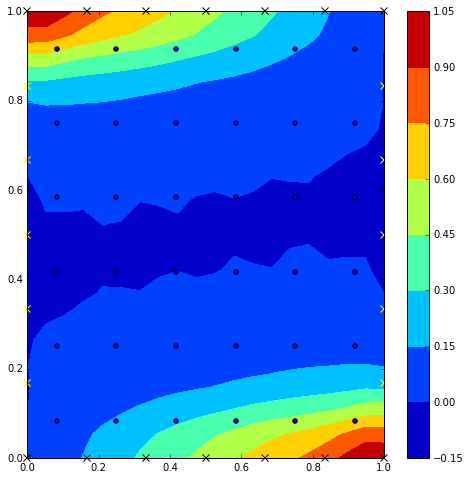

In [167]:
plt.figure(figsize=(8,8))
import matplotlib.tri as tri
#plt.tripcolor(test_x.ravel(), test_y.ravel(), mu.ravel())
colors = plt.contourf(test_x, test_y, mu_shaped)
plt.colorbar(colors)
plt.scatter(interior[:,0], interior[:,1])
plt.scatter(neumann[:,0], neumann[:,1], marker='x', c='yellow', clip_on=False, s=50)
plt.scatter(dirichlet[:,0], dirichlet[:,1], marker='x', c='black', clip_on=False, s=50)
plt.xlim(0,1); plt.ylim(0,1);


In [124]:
from scipy import stats

In [125]:
def propose(current):
    return np.random.normal(current, proposal_sigma)
def proposal_proba(proposal, current):
    return stats.multivariate_normal.logpdf(proposal, current, proposal_sigma)
def log_likelihood(theta):
    posterior = bpdes.collocate(ops, ops_bar, k, None, obs, op_cache, [theta])
    mu,cov = posterior(true_x)
    cov_with_error = cov + likelihood_sigma**2*np.eye(cov.shape[0])
    #ret = stats.multivariate_normal.logpdf(true_u, mu.ravel(), cov_with_error, False)
    #return ret
    err = (true_u - mu.ravel()).reshape((mu.shape[0], 1))
    cov_inv = np.linalg.inv(cov_with_error)
    inner = -0.5*err.T.dot(cov_inv).dot(err)
    outer = -0.5*np.log(np.linalg.det(2*np.pi*cov_with_error))
    return (inner + outer)[0,0]
def log_prior(theta):
    return stats.multivariate_normal.logpdf(theta, np.zeros_like(theta), 1.)

In [168]:
import pymc
like_sigma = 0.05
theta = pymc.Normal('Theta', 0, 1, size=6, value=np.ones(6))
#@pymc.stochastic(observed=True, plot=False)
@pymc.potential
def bcol_likelihood(value=true_u, theta_act=theta):
    posterior = bpdes.collocate(ops, ops_bar, k, None, obs, op_cache, [theta_act])
    mu,cov = posterior(true_x)
    ret =  pymc.mv_normal_cov_like(value, mu, cov + like_sigma**2*np.eye(cov.shape[0]))
    return ret

mcmc = pymc.MCMC([theta, bcol_likelihood])
mcmc.use_step_method(pymc.AdaptiveMetropolis, [theta], scales={theta:0.5*np.ones(6)}, delay=5000)
mcmc.sample(10000,5000)

 [-----------      31%                  ] 3131 of 10000 complete in 88.9 secHalting at iteration  3133  of  10000


Plotting Theta_0
Plotting Theta_1
Plotting Theta_2
Plotting Theta_3
Plotting Theta_4
Plotting Theta_5


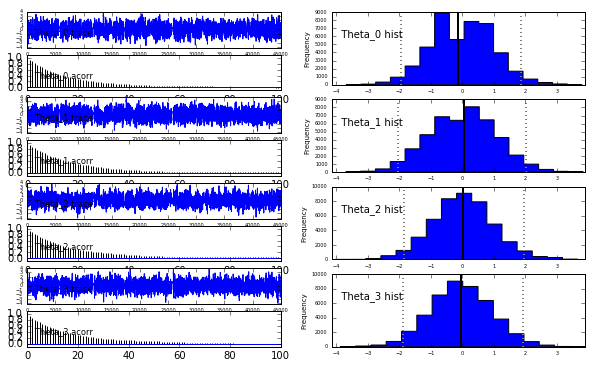

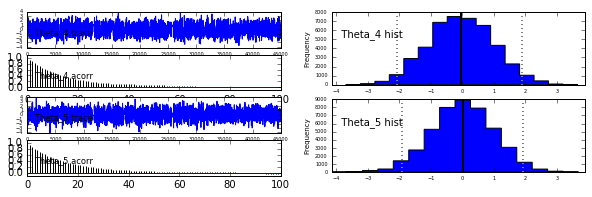

In [161]:
pymc.Matplot.plot(mcmc)

In [162]:
tr = mcmc.trace(theta)[:]

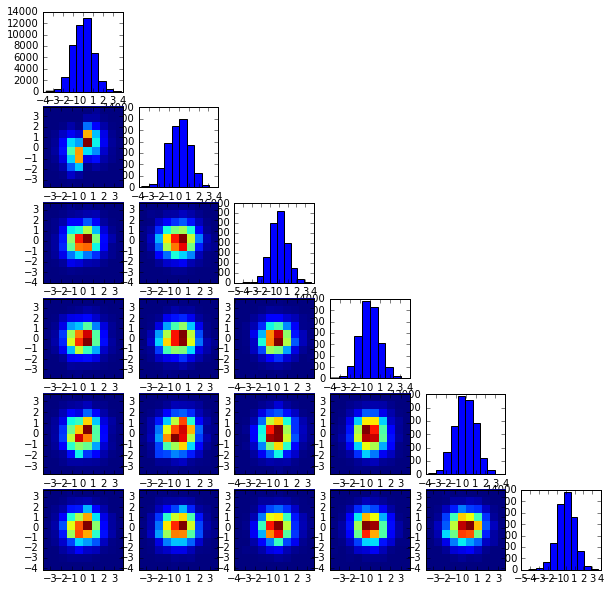

In [163]:
plt.figure(figsize=(10,10))
for i in range(6):
    plt.subplot(6,6,6*i + i + 1)
    plt.hist(tr[:,i])
    for j in range(0,i):
        plt.subplot(6,6,6*i+j+1)
        plt.hist2d(tr[:,j], tr[:,i])

In [ ]:
init_theta = np.ones(6)

In [ ]:
#cur_theta = true_theta.copy()
# now the MCMC
iterations = 5000
thetas = np.empty((iterations, cur_theta.shape[0]))
proposals = np.empty((iterations, cur_theta.shape[0]))
thetas[0,:] = init_theta
proposal_sigma = 0.2
likelihood_sigma = 0.2

last_likelihood = log_likelihood(thetas[0,:])
last_prior = log_prior(thetas[0,:])
acceptances = np.empty(iterations, dtype=np.bool)
acceptances[0] = True
alphas = np.empty(iterations)

cur_theta = init_theta
for i in xrange(iterations):
    next_theta = propose(cur_theta)
    proposals[i,:] = next_theta
    
    new_likelihood = log_likelihood(next_theta)
    new_prior = log_prior(next_theta)
    alpha = np.exp(new_likelihood + new_prior)*np.exp(-(last_likelihood + last_prior))
    if np.isnan(alpha): 
        accept = False #
    else:
        accept = np.random.uniform() < alpha
    alphas[i] = alpha
    acceptances[i] = accept
    if accept == True:
        #print 'Accepted'
        cur_theta = next_theta
        last_likelihood = new_likelihood
        last_prior = new_prior
    
    thetas[i,:] = cur_theta


In [ ]:
print acceptances.sum() * 1./iterations
for i in xrange(6):
    plt.plot(thetas[:,i], label='theta {}'.format(i+1))
plt.legend(loc=2, bbox_to_anchor=(1.05,1))

In [ ]:
np.exp(-last_likelihood - last_prior)

In [ ]:
np.exp(new_likelihood + new_prior)

In [ ]:
posterior = bpdes.collocate(ops, ops_bar, k, None, obs, op_cache, [cur_theta])
mu,cov = posterior(true_x)

In [ ]:
np.dot(mu.ravel()-true_u, np.linalg.inv(cov+likelihood_sigma**2*np.eye(cov.shape[0]))).dot(mu.ravel()-true_u)

In [ ]:
np.exp(0.5*np.log(np.linalg.det(cov+likelihood_sigma**2*np.eye(cov.shape[0]))) + np.dot(mu.ravel()-true_u, np.linalg.inv(cov+likelihood_sigma**2*np.eye(cov.shape[0]))).dot(mu.ravel()-true_u))